IMPORTING NECESSARY LIBRARIES, MODELS AND EVALUATION METRICS

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Download NLTK resources (only needed once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lavanya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lavanya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lavanya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lavanya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

LOADING DATASET AND EDA

In [4]:
# Load the dataset
df = pd.read_csv('hospital.csv')

# Display the shape of the dataset
print("Shape of dataset:", df.shape)

# Display the column names
print("\nColumns in dataset:", df.columns.tolist())

# Display the first few rows
print("\nSample rows:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Shape of dataset: (996, 4)

Columns in dataset: ['Feedback', 'Sentiment Label', 'Ratings', 'Unnamed: 3']

Sample rows:
                                            Feedback  Sentiment Label  \
0  Good and clean hospital. There is great team o...                1   
1  Had a really bad experience during discharge. ...                1   
2  I have visited to take my second dose and Proc...                1   
3   That person was slightly clueless and offered...                1   
4  There is great team of doctors and good OT fac...                0   

   Ratings  Unnamed: 3  
0        5         NaN  
1        5         NaN  
2        4         NaN  
3        3         NaN  
4        1         NaN  

Missing values in each column:
Feedback             0
Sentiment Label      0
Ratings              0
Unnamed: 3         996
dtype: int64


In [5]:
df.drop(columns=['Unnamed: 3'], inplace=True) # Dropping Unnecessary column

In [8]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back into a single string
    return ' '.join(tokens)

In [9]:
df['Cleaned_Feedback'] = df['Feedback'].apply(preprocess_text)

In [10]:
df.head()

,Feedback,Sentiment Label,Ratings,Cleaned_Feedback
0,Good and clean hospital. There is great team o...,1,5,good clean hospital great team doctor good ot ...
1,Had a really bad experience during discharge. ...,1,5,really bad experience discharge need sensitive...
2,I have visited to take my second dose and Proc...,1,4,visited take second dose process really smooth...
3,That person was slightly clueless and offered...,1,3,person slightly clueless offered one package g...
4,There is great team of doctors and good OT fac...,0,1,great team doctor good ot facility


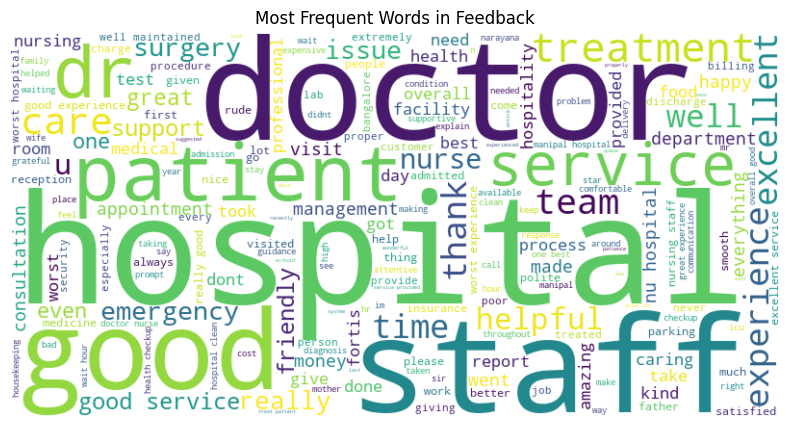

In [11]:
# Combine all text into one string
all_words = ' '.join(df['Cleaned_Feedback'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Feedback')
plt.show()

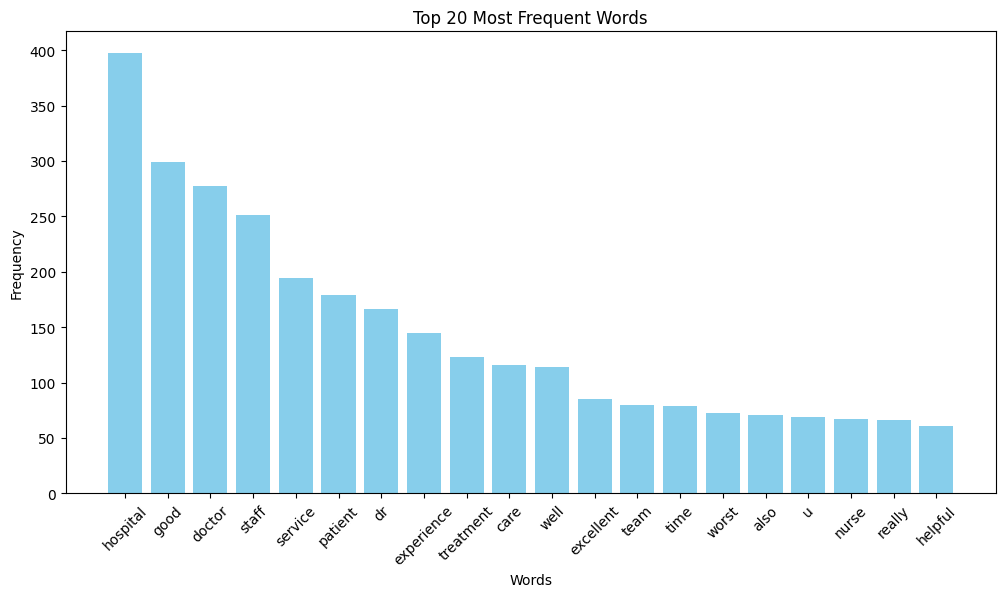

In [12]:
# Count word frequencies
word_counts = Counter(all_words.split())

# Get top 20 most common words
top_words = word_counts.most_common(20)

# Separate words and counts
words, counts = zip(*top_words)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

CONVERTING TEXT FOR TRANING, TESTING AND MODEL BUILDING

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform on cleaned feedback
X = tfidf.fit_transform(df['Cleaned_Feedback'])

# Target variable
y = df['Sentiment Label']

In [14]:
# Train- Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE - Since "Sentiment Label" has imbalance data to train
smote = SMOTE(random_state=40)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_resampled.value_counts())

# Train model on balanced data
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Evaluate on test set (not resampled)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Before SMOTE: Sentiment Label
1    586
0    210
Name: count, dtype: int64
After SMOTE: Sentiment Label
0    586
1    586
Name: count, dtype: int64
Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.75      0.84      0.80        58
           1       0.93      0.89      0.91       142

    accuracy                           0.88       200
   macro avg       0.84      0.87      0.85       200
weighted avg       0.88      0.88      0.88       200

Confusion Matrix:
 [[ 49   9]
 [ 16 126]]


In [15]:
# For Evaluating Logistic Regression- ROC-AUC
lr_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("Logistic Regression ROC-AUC Score:", lr_auc)

Logistic Regression ROC-AUC Score: 0.9372268091306459


ROC-AUC Score: 0.9372268091306459


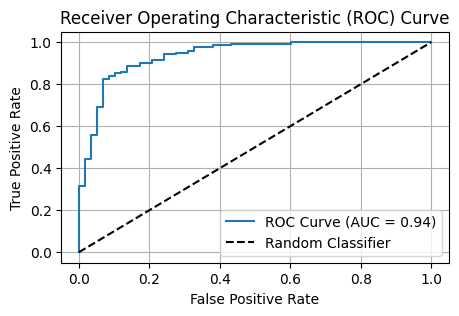

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities on the test set
y_proba = model.predict_proba(X_test)[:, 1]  # probability of positive class

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(5,3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],            # Regularization strength
    'penalty': ['l2'],            # Only l2 supported by solver='lbfgs'
    'solver': ['lbfgs']
}

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000)

# Grid search with 5-fold cross-validation
grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid.best_params_)

# Predictions with best model
y_pred = grid.best_estimator_.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.855
Confusion Matrix:
 [[ 38  20]
 [  9 133]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.66      0.72        58
           1       0.87      0.94      0.90       142

    accuracy                           0.85       200
   macro avg       0.84      0.80      0.81       200
weighted avg       0.85      0.85      0.85       200



SAVING THE MODEL- DEPLOYMENT

In [19]:
import joblib

# Save the trained logistic regression model
joblib.dump(model, 'logistic_regression_sentiment_model_nlp.pkl')

['logistic_regression_sentiment_model_nlp.pkl']

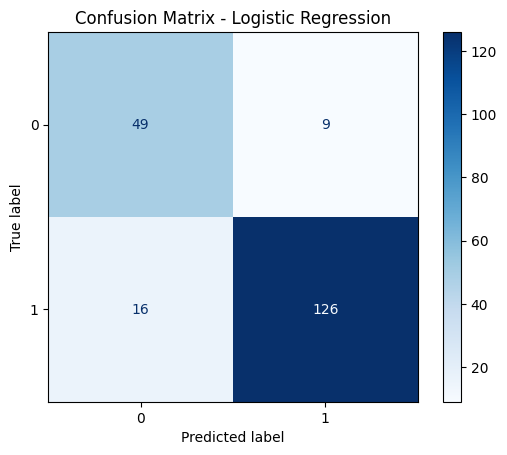

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()